In [1]:
# !pip install --upgrade pip
# !pip install  rasterio
import numpy as np
import pywt
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os 
from PIL import Image
Image.MAX_IMAGE_PIXELS = 900_000_000
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
from collections import Counter
import zipfile 
import urllib.request
import random
import functools as fct
import math as mt
import rasterio
import rasterio.features
import rasterio.warp
from skimage.color import rgb2gray
import pywt
import io
import json
import datetime

In [2]:
# We need a function to convert lat, long into pixel location. The 
# `transform` method gives us the affine relationship with which to 
# accomplish this.  The transform however is from pixel indices
# to spatial coordinates. We require the opposite.
#
# Specifically, the location 𝗹 = 𝗔 𝗽 + 𝗯, where 𝗽 are the pixel
# coordinates, 𝗔 is the coefficient matrix of the affine transform,
# and 𝗯 is the intercept.  We want pixel location 𝗽 = (𝗹 - 𝗯)𝗔⁻¹.  
# We calculate this for individual pixels and for groups.

# Convert the transform object into coefficient matrix 𝗔 and
# intercept vector 𝗯. 
def λ_pixel(λ_coord, affine_xform):
    𝗔 = np.reshape(a = np.array(affine_xform[:6]),
                   newshape = (2,3))[:,:2]
    𝗯 = np.expand_dims(a = np.reshape(a = np.array(affine_xform[:6]),
                                      newshape = (2,3))[:,-1],
                       axis = -1)
    #
    # Calculate and return the pixel location.
    return int((λ_coord - 𝗯.item(1)) * np.linalg.inv(𝗔).item(1,1))
def 𝘓_pixel(𝘓_coord, affine_xform):
    𝗔 = np.reshape(a = np.array(affine_xform[:6]),
                   newshape = (2,3))[:,:2]
    𝗯 = np.expand_dims(a = np.reshape(a = np.array(affine_xform[:6]),
                                      newshape = (2,3))[:,-1],
                       axis = -1)
    #
    # Calculate and return the pixel location.
    return int((𝘓_coord - 𝗯.item(0)) * np.linalg.inv(𝗔).item(0,0))

In [3]:
# ACQUIRE COUNTRY-WIDE POPULATION-DENSITY MAP. 
# Our procedure comes from StackOverflow:
#         https://discuss.analyticsvidhya.com/t/how-to-read-zip-file-directly-in-python/1659
# 
urllib.request.urlretrieve('https://data.humdata.org/dataset/cbfc4206-35c8-42d4-a096-b2dd0aec983d/resource/1b7e9361-651a-4bf2-839b-eaf5c5f45ec1/download/population_zaf_2018-10-01.csv.zip',
                           'sa_pop.zip')
sa_pop_zip = zipfile.ZipFile('sa_pop.zip')
sa_pop_csv = pd.read_csv(filepath_or_buffer = sa_pop_zip.open('population_zaf_2018-10-01.csv'))

In [4]:
# Read in image layer — a bitmap image exported from Google Maps and georeferenced in QGIS.
dataset = rasterio.open('./Assets/J-berg O-head Imagery/200216 J-Berg O-head Image_modified.tif')
# dataset = rasterio.open('./Assets/J-berg O-head Imagery/200216 J-Berg O-head Image_modified.jpg')



In [5]:
# Estimate imagery resolution.  One degree of longitidue is approximately
# 111.32 km. From our dataset.bounds attribute we get the bounding
# latitudes. The dataset.height attribute gives us the vertical
# pixel count.
image_res = (dataset.bounds.top - dataset.bounds.bottom)*111.32*1000/dataset.height
print(f'Approximate image resolution: {round(image_res, 1)} meters per pixel.')

Approximate image resolution: 4.9 meters per pixel.


In [6]:
# Window country-wide data to our rectangular Johannesberg region window. 
jberg_pop = sa_pop_csv.loc[ (sa_pop_csv['Lat'].between(left = dataset.bounds.bottom,
                                                       right = dataset.bounds.top)) &\
                            (sa_pop_csv['Lon'].between(left = dataset.bounds.left,
                                                         right = dataset.bounds.right))]
jberg_pop.head(n = 10)

,Lat,Lon,Population
3188199,-26.062361,27.952361,10.03537
3188200,-26.062361,27.953472,10.03537
3188201,-26.062361,27.954028,10.03537
3188202,-26.062361,27.954861,10.03537
3188203,-26.062361,27.955139,10.03537
3188204,-26.062361,27.955417,10.03537
3188205,-26.062361,27.957083,5.31409
3188206,-26.062361,27.957361,5.31409
3188207,-26.062361,27.957639,5.31409
3188208,-26.062361,27.958194,5.31409


In [7]:
# Convert the georeferenced population-estimates to pixel coordinates so 
# that we can scatter-plot them into the image.
𝗔 = np.reshape(a = np.array(dataset.transform[:6]),
               newshape = (2,3))[:,:2]
𝗯 = np.expand_dims(a = np.reshape(a = np.array(dataset.transform[:6]),
                                  newshape = (2,3))[:,-1],
                   axis = -1)
jberg_pop_pix_raster = pd.DataFrame(data = np.dot(b = np.ndarray.transpose(jberg_pop[['Lon', 'Lat']].to_numpy() - np.transpose(𝗯)),
                                                   a = np.linalg.inv(𝗔)),
                                     index = ['Longitude, L', 'Latitude, λ'],
                                     columns = jberg_pop.index).T\
                                                               .astype(int)#\
#                                                                .assign(λ = lambda Ξ : dataset.height - Ξ['Latitude, λ'])\
#                                                                .drop(labels = 'Latitude, λ',
#                                                                      axis = 1)\
#                                                                .rename(columns = {'λ' : 'Latitude, λ'})
jberg_pop_pix_raster.head(n = 10)

,"Longitude, L","Latitude, λ"
3188199,1,5
3188200,26,5
3188201,39,5
3188202,57,5
3188203,64,5
3188204,70,5
3188205,107,5
3188206,114,5
3188207,120,5
3188208,133,5


In [15]:
jberg_pop_pix_raster.shape

(94122, 2)

In [8]:
# Specify frame ticks and labels for our image plot.  The matplotlib.pyplot.imshow
# defaults to pixels in each dimension. We want to look at things in terms
# of (λ, 𝘓).
𝘓_ticks_labels = [round(tick_lab, 4)
                      for tick_lab in np.arange(start = 27.95,
                                               stop = 28.17,
                                               step = 0.01)]
𝜆_ticks_labels = [round(tick_lab, 4)
                    for tick_lab in np.arange(start = -26.06,
                                               stop = -26.20,
                                               step = -0.01)]
𝘓_ticks = [𝘓_pixel(tick_tab, dataset.transform)
                for tick_tab in 𝘓_ticks_labels]
𝜆_ticks = [dataset.height - 𝜆_pixel(tick_tab, dataset.transform)
                for tick_tab in 𝜆_ticks_labels]

In [9]:
# Geo-window our data so that we only process the population measurements
# within an area not marked by our Google-maps pins used to georeference
# the image we got from it.
process_window = {'λ' : {'South' : -26.152,
                        'North' : -26.07125},
                 '𝘓' : {'West' : 27.96,
                        'East' : 28.135}}
processing_box_geo = np.array([[process_window.get('𝘓').get('West'), process_window.get('𝘓').get('East'),
                                process_window.get('𝘓').get('East'), process_window.get('𝘓').get('West'),
                                process_window.get('𝘓').get('West')],
                               [process_window.get('λ').get('South'), process_window.get('λ').get('South'),
                                process_window.get('λ').get('North'), process_window.get('λ').get('North'),
                                process_window.get('λ').get('South')]])
processing_box_pixel = np.dot(b = processing_box_geo - 𝗯,
                              a = np.linalg.inv(𝗔)).astype(int)
processing_box_pixel[1,:] = dataset.height - processing_box_pixel[1,:]

In [10]:
# Window Johannesberg data to our processing box. Then convert (λ, 𝘓) to
# pixel indices.
jberg_proc_window = jberg_pop.loc[jberg_pop['Lat'].between(right = process_window.get('λ').get('North'),
                                                           left = process_window.get('λ').get('South')) &\
                                  jberg_pop['Lon'].between(left = process_window.get('𝘓').get('West'),
                                                           right = process_window.get('𝘓').get('East'))]
jberg_proc_raster = pd.DataFrame(data = np.dot(b = jberg_proc_window[['Lon', 'Lat']]\
                                                                     .T\
                                                                     .to_numpy() - 𝗯,
                                               a = np.linalg.inv(𝗔)).astype(int),
                                 index = ['pix_Lon', 'pix_Lat'],
                                 columns = jberg_proc_window.index).T
jberg_proc_raster.head()

,pix_Lon,pix_Lat
3207306,176,206
3207307,183,206
3207308,202,206
3207309,214,206
3207310,227,206


In [17]:
jberg_proc_raster.shape

(65943, 2)

In [11]:
# Extract our RGB image out of the rasterio object and convert it to 
# a gray-scale array.  We do this in two steps.  We first use
# list comperemension to extract each band. We then use the scikit-image
# rgb-to-gray scale to combine the color channels. 
jberg_img_array = rgb2gray(np.stack(arrays = [dataset.read(band_idx)
                                               for band_idx in dataset.indexes],
                                     axis = -1))



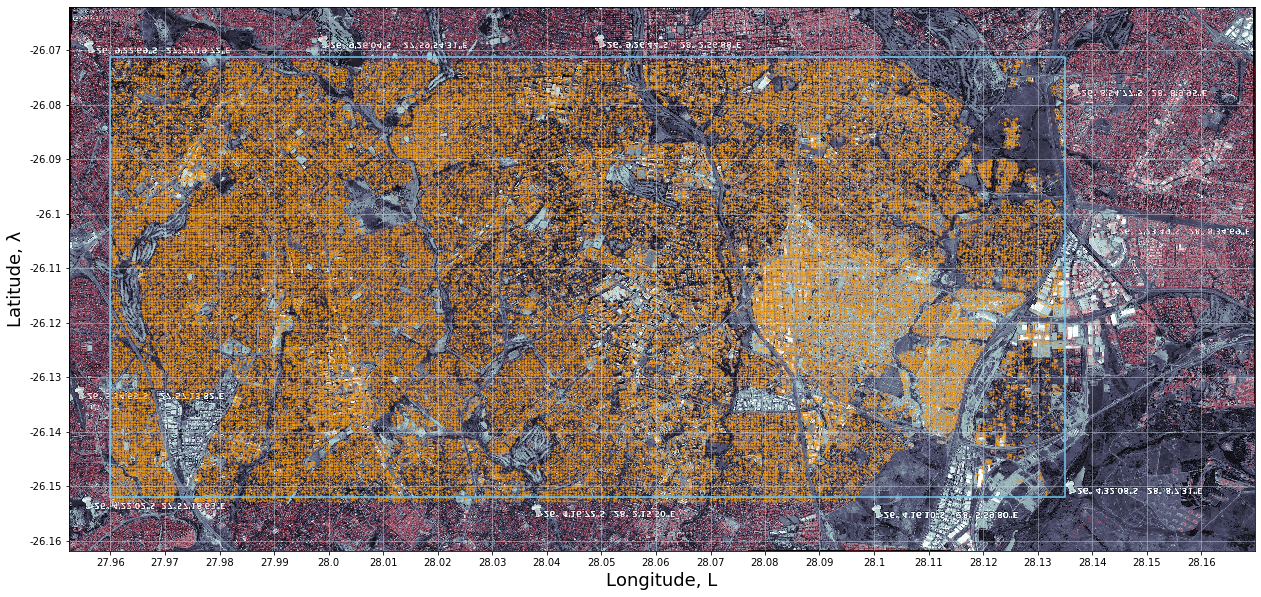

In [13]:
plt.figure(figsize = (22,10))
plt.imshow(jberg_img_array,
           cmap = 'bone')
plt.xticks(ticks = 𝘓_ticks,
           labels = 𝘓_ticks_labels);
plt.yticks(ticks = 𝜆_ticks,
           labels = 𝜆_ticks_labels);
plt.xlim(left = 0, 
         right = dataset.width),
plt.ylim(bottom = 0,
         top = dataset.height);
plt.xlabel(xlabel = 'Longitude, L',
           fontsize = 18)
plt.ylabel(ylabel = 'Latitude, λ',
           fontsize = 18);
plt.scatter(jberg_pop_pix_raster['Longitude, L'],
            jberg_pop_pix_raster['Latitude, λ'],
            s = 2,
            color = '#ff304225');
plt.scatter(jberg_proc_raster['pix_Lon'],
            jberg_proc_raster['pix_Lat'],
            s = 1,
            color = '#f2a90075');
# plt.title(label = 'Facebook population measurement overlaid \n onto overhead image of target area',
#           fontsize = 28,
#           color = '#003459');
plt.plot(processing_box_pixel[0,:],
         processing_box_pixel[1,:],
         color = '#73cbf2');
plt.grid(color = '#dde5ed',
         alpha = 0.5)
plt.savefig(fname = './Graphics/pop_density_geo_overlay.png',
            dpi = 150,
            transparent = True,
            bbox_inches = 'tight')


In [ ]:
# Calculate Euclidian distances.


# Get the kMeans model-fit labels from an external json file.  It comes to us in 
# the form of a dictionary, 
#    {n_clust  : {silhouette_score : ...,
#                  labels : ...}}
kmeans_fit_params = json.loads(open('./Assets/J-berg O-head Imagery/pop_geo_dwt_kmeans_fit_lvl3_win128_unscaled.json').read())
#
# Group all of our population-measurements by the cluster to which they were assigned. We
# need some pandas gymnastics.  Also, we are interested in our image-pixel reference frame.
# So we work on that.  We specifically want the centriods, and the location of the 90th 
# percentile.  
jberg_proc_raster_labeled = jberg_proc_raster.assign(cluster = kmeans_fit_params.get('45').get('labels'))
clust_centroids = jberg_proc_raster_labeled.groupby(by = 'cluster')\
                                           .mean()\
                                           .astype(int)\
                                           .rename(columns = {'pix_Lon' : '𝘓_cent',
                                                              'pix_Lat' : 'λ_cent' })
#
# Identify viable clusters, for which membership exceeds arbitrarily-selected threshold
# of 500.  We find single-member clusters, which are uninteresting for us.
viable_clusters = jberg_proc_raster.assign(cluster = kmeans_fit_params.get('45').get('labels'))\
                                   .groupby(by = 'cluster')\
                                   .count()\
                                   [['pix_Lon']]\
                                   .reset_index()\
                                   .assign(exceeds_min_count = lambda Ξ : Ξ['pix_Lon'] >= 500)\
                                   .set_index(keys = 'exceeds_min_count')\
                                   .loc[True, 'cluster']\
                                   .tolist()
#
# To visualize the distribution contours — using seaborn.kdeplot — we want to 
# truncate our measurements to include only the top quartile of each cluster,
# in terms of distance from the cluster centroid.  We first calculate the Euclidian
# distance of each measurement from its centriod.  We then calculate the 
# value of the specified quantile.  Finally, we filter the data frame,
# retaining only the records within a specified upper-bound distance from
# the centroid.
distance_from_centroid = pd.merge(left = jberg_proc_raster_labeled.rename_axis(index = 'meas_pt')\
                                                                  .reset_index(),
                                  right = clust_centroids.reset_index())\
                            .assign(cent_dist = lambda Ξ : np.sqrt(np.square(Ξ['pix_Lon'] - Ξ['𝘓_cent']) +\
                                                                  np.square(Ξ['pix_Lon'] - Ξ['𝘓_cent'])))
cluster_thold_quantile = pd.concat(objs = [distance_from_centroid[['cluster', 'cent_dist']]\
                                                                   .set_index(keys = 'cluster')\
                                                                   .loc[cluster]\
                                                                   .assign(thold_quantile = lambda Ξ : Ξ['cent_dist'].quantile(q = 0.2))\
                                                                   .reset_index()\
                                                                   .drop(labels = 'cent_dist',
                                                                         axis = 1)\
                                                                   .drop_duplicates()
                                                for cluster in viable_clusters],
                                      axis = 0)
within_dist_thold = pd.merge(left = distance_from_centroid,
                             right = cluster_thold_quantile)\
                                .assign(within_dist_thold = lambda Ξ : Ξ['cent_dist'] <= Ξ['thold_quantile'])\
                                .set_index(keys = 'within_dist_thold')\
                                .loc[True]\
                                .set_index(keys = 'cluster')

In [ ]:
(fig, ax) = plt.subplots(1, 1,
                         figsize = (22,10))
ax.imshow(jberg_img_array,
          cmap = 'bone',
          alpha = 0.8)
ax.plot(processing_box_pixel[0,:],
         processing_box_pixel[1,:],
         color = '#73cbf2');
ax.set_xticks(ticks = 𝘓_ticks);
ax.set_xticklabels(labels = 𝘓_ticks_labels);
ax.set_yticks(ticks = 𝜆_ticks);
ax.set_yticklabels(labels = 𝜆_ticks_labels);
ax.set_xlim(left = 0, 
            right = dataset.width),
ax.set_ylim(bottom = 0,
            top = dataset.height);



for clust_label in viable_clusters: 
    X, Y = np.meshgrid(within_dist_thold.loc[clust_label, 'pix_Lon'],
                       within_dist_thold.loc[clust_label, 'pix_Lat'])
    Z = np.sqrt(np.square(X - within_dist_thold.loc[clust_label, '𝘓_cent']\
                                               .values.item(0)) +\
                np.square(Y - within_dist_thold.loc[clust_label, 'λ_cent']\
                                               .values.item(0)))
    ax.contour(X, Y, Z,
               colors  = '#0051ba',
               alpha = 0.25,
               levels = [within_dist_thold.loc[clust_label, 'cent_dist']\
                                          .quantile(q = 0.1),
                         within_dist_thold.loc[clust_label, 'cent_dist']\
                                          .quantile(q = 0.2)])


ax.set_xlabel(xlabel = 'Longitude, L',
           fontsize = 18)
ax.set_ylabel(ylabel = 'Latitude, λ',
              fontsize = 18);
plt.grid(color = '#dde5ed',
         alpha = 0.5)


plt.savefig(fname = './Graphics/cluster_contours.png',
            dpi = 240,
            transparent = True,
            bbox_inches = 'tight')



In [ ]:
sns.kdeplot(data =within_dist_thold.loc['1', 'pix_Lon'],
            data2 = within_dist_thold.loc['1', 'pix_Lat'],
            cmap = 'Blues')
# plt.xticks(ticks = 𝘓_ticks,
#            labels = 𝘓_ticks_labels);
# plt.yticks(ticks = 𝜆_ticks,
#            labels = 𝜆_ticks_labels);





In [ ]:
# Generate a model-data matrix for which the explanatory variables include the
# lat and long (λ, 𝘓), the population measurements, and discrete wavelet-transform
# coefficients from a 128×128-pixel window centered on the population-density
# measurement. Once scaled, this will be the data for a k-means clustering
# analysis of the data. 
#
# We operate on our jberg_proc_raster dataframe, in which we identified
# all of the measurements within our processing "box" and identified
# their pixel indices.  These indices form the center of our 128×128-pixel
# windows for DWT analysis.
#
# ⓵ Initialize a dictionary in which to collect the data.
pop_geo_dwt_dict = dict()

# ⓶ Now, cycle through all of the indices for our jberg_proc_raster data frame
#   whose columns contain pixel-indices for each population-density measurement.
for pop_meas in jberg_proc_raster.index:
    # ⓐ Extract from our image array the 128×128-pixel window.  The image array
    #    is gray-scale, so our windows are two-dimensional.
    dwt_window = jberg_img_array[(jberg_proc_raster.loc[pop_meas, 'pix_Lat'] - 64):(jberg_proc_raster.loc[pop_meas, 'pix_Lat'] + 64),
                                 (jberg_proc_raster.loc[pop_meas, 'pix_Lon'] - 64):(jberg_proc_raster.loc[pop_meas, 'pix_Lon'] + 64)]
    #
    # ⓑ Calculate a three-level DWT on each window.  Use the length-four Daubechies wavelet
    #    filter.  It is strictly real, and it provides perfect-reconstruction.
    dwt_xform = pywt.wavedec2(data = dwt_window,
                              wavelet = 'db3',
                              level = 3)
    #
    # ⓒ Collect all of our explanatory variables a one-dimensional numpy array.
    #    For each population-density measurement, we append together three
    #    sources:
    #     ⅰ. The lat, long, and population-density measurement from our ouriginal data
    #        matrix;
    #     ⅱ. The zeroth array returned by the dwt, which represents the final approximation; and
    #     ⅲ. All of the detail arrays. 
    #    We end up with a dictionary for which the keys are the indices from the
    #    population-density measurements in our processing box, and the values are
    #    the above-described variables.  We use in-place dictionary.update method
    #    to append each new (key, val) pair to the dictionary as we calculate.
    #
    #    Since we have to concatenate more than two arrays via the numpy.append,
    #    we use the functools.reduce applied to a lambda operator.
    pop_geo_dwt_dict.update({pop_meas : fct.reduce(lambda Ξ, Ζ : np.append(Ξ, Ζ),
                                                                 [jberg_pop.loc[pop_meas].to_numpy(),
                                                                  np.ndarray.flatten(dwt_xform[0]),
                                                                  np.ndarray.flatten(np.stack(arrays = dwt_xform[1],
                                                                             axis = -1))])})
#
# ⓷ Transform all of our information into a data frame.
pop_geo_dwt_df = pd.DataFrame.from_dict(data = pop_geo_dwt_dict,
                                        orient = 'index')




In [ ]:
jberg_proc_window.loc[jberg_proc_window['Lon'].between(left = 27.9825,
                                                                       right = 27.9875) &\
                                      jberg_proc_window['Lat'].between(left = -26.1005,
                                                                       right = -26.0955)].head(n = 10)

In [ ]:
# PLOT SELECTED DWT FOR ILLUSTRATION PURPOSES.
# ⓵ First plot a "nice" window in the vincity of 27.985𝘓, -26.115λ.
#    ⓐ Find measurement indices in our window of interest
window_center = jberg_proc_window.loc[jberg_proc_window['Lon'].between(left = 27.9825,
                                                                       right = 27.9875) &\
                                      jberg_proc_window['Lat'].between(left = -26.1005,
                                                                       right = -26.0955)].index\
                                                                                         .tolist()\
                                                                                         [5]
#    ⓑ Extract a 128×128-pixel window centered on this measurement.
img_window_pixels = {'𝘓' : np.arange(start = jberg_proc_raster.loc[window_center, 'pix_Lon'] - 128,
                                     stop = jberg_proc_raster.loc[window_center, 'pix_Lon'] + 128),
                     'λ' : np.arange(start = jberg_proc_raster.loc[window_center, 'pix_Lat'] - 128,
                                     stop = jberg_proc_raster.loc[window_center, 'pix_Lat'] + 128)}
img_window = pd.DataFrame(jberg_img_array).loc[img_window_pixels.get('𝘓'),
                                               img_window_pixels.get('λ')]\
                                          .to_numpy()
#
#    ⓒ Calculate the dwt for our image window.  Collect the coefficient
#       arrays in nested dictionaries.  The `wevdec2` function
#       returns arrays in decreasing level.
img_window_dwt = pywt.wavedec2(data = img_window,
                               wavelet = 'db3',
                               level = 4,
                               mode = 'symmetric')
dwt_coef_mtx = dict(zip(np.arange(start = 4,
                                   stop = 0,
                                   step = -1),
                         [dict(zip(['cH', 'cV', 'cD'],
                                          img_dwt))
                                     for img_dwt in img_window_dwt[1:]]))
dwt_coef_mtx.get(4).update({'cA' : img_window_dwt[0]})

#    ⓒ Now our `pwt.wavedec2` algorithm only produces the approximations
#       at each level.  We want to reintroduce the approximations.  We have to
#       loop through our dictionary and reconstruct the approximation from
#       the constituent approximations and details.
for dwt_lvl in np.arange(start = 4,
                         stop = 1,
                         step = -1):
    cA_shape = dwt_coef_mtx.get(dwt_lvl).get('cA').shape[0]
    cX_shape = dwt_coef_mtx.get(dwt_lvl).get('cH').shape[0]
    cX_shape = np.min([cA_shape, cX_shape])
    dwt_coef_mtx.get(dwt_lvl - 1).update({'cA' : 
                    pywt.idwt2(coeffs = (dwt_coef_mtx.get(dwt_lvl).get('cA')[:cX_shape, :cX_shape],
                                         (dwt_coef_mtx.get(dwt_lvl).get('cH')[:cX_shape, :cX_shape],
                                          dwt_coef_mtx.get(dwt_lvl).get('cV')[:cX_shape, :cX_shape],
                                          dwt_coef_mtx.get(dwt_lvl).get('cD')[:cX_shape, :cX_shape])),
           wavelet = 'db3',
           mode = 'symmetric')    })
#
# ⓶ Construct a raster of plots of the DWT coefficients.
dwt_orient = dict(enumerate(['cA', 'cH', 'cV', 'cD']))
fig, axes = plt.subplots(4, 5,
                         figsize = (20, 15))
for dwt_lvl in np.arange(start = 1,
                         stop = 5):
    for orient_key in dwt_orient.keys():
        axes[orient_key, dwt_lvl].imshow(X = dwt_coef_mtx.get(dwt_lvl).get(dwt_orient.get(orient_key)),
                                         cmap = 'bone')
        axes[orient_key, dwt_lvl].set_xticks([])
        axes[orient_key, dwt_lvl].set_yticks([])
        axes[orient_key, dwt_lvl].spines['top'].set_color('#003459')
        axes[orient_key, dwt_lvl].spines['bottom'].set_color('#003459')
        axes[orient_key, dwt_lvl].spines['left'].set_color('#003459')
        axes[orient_key, dwt_lvl].spines['right'].set_color('#003459')
        axes[orient_key, dwt_lvl].set_aspect('equal')
        axes[orient_key, dwt_lvl].set_title(label = f'DWT Level {dwt_lvl}, Orientation {dwt_orient.get(orient_key)}')
        axes[orient_key, dwt_lvl].imshow(X = dwt_coef_mtx.get(dwt_lvl).get(dwt_orient.get(orient_key)),
                                         cmap = 'bone')
axes[0, 0].imshow(X = img_window,
                  cmap = 'bone')
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])
axes[0, 0].spines['top'].set_color('#003459')
axes[0, 0].spines['bottom'].set_color('#003459')
axes[0, 0].spines['left'].set_color('#003459')
axes[0, 0].spines['right'].set_color('#003459')
axes[0, 0].set_aspect('equal')
axes[0, 0].set_title(label = 'Original image')
for orient_key in [1,2,3]:
    axes[orient_key, 0].set_xticks([])
    axes[orient_key, 0].set_yticks([])
    axes[orient_key, 0].spines['top'].set_color('#00345900')
    axes[orient_key, 0].spines['bottom'].set_color('#00345900')
    axes[orient_key, 0].spines['left'].set_color('#00345900')
    axes[orient_key, 0].spines['right'].set_color('#00345900')
plt.tight_layout(pad = 0)

plt.savefig(fname = './Graphics/nice_area_dwt.png',
            dpi = 240,
            transparent = True,
            bbox_inches = 'tight')

In [ ]:
# PLOT SELECTED DWT FOR ILLUSTRATION PURPOSES.
# ⓵ First plot a "slum" window in the vincity of 28.095𝘓, -26.12λ.
#    ⓐ Find measurement indices in our window of interest
window_center = jberg_proc_window.loc[jberg_proc_window['Lon'].between(left = 28.0945,
                                                                       right = 28.0955) &\
                                      jberg_proc_window['Lat'].between(left = -26.121,
                                                                       right = -26.119)].index\
                                                                                         .tolist()\
                                                                                         [5]
#    ⓑ Extract a 128×128-pixel window centered on this measurement.
img_window_pixels = {'𝘓' : np.arange(start = jberg_proc_raster.loc[window_center, 'pix_Lon'] - 128,
                                     stop = jberg_proc_raster.loc[window_center, 'pix_Lon'] + 128),
                     'λ' : np.arange(start = jberg_proc_raster.loc[window_center, 'pix_Lat'] - 128,
                                     stop = jberg_proc_raster.loc[window_center, 'pix_Lat'] + 128)}



img_window = pd.DataFrame(jberg_img_array).loc[img_window_pixels.get('λ'),
                                               img_window_pixels.get('𝘓')]\
                                          .to_numpy()
#
#    ⓒ Calculate the dwt for our image window.  Collect the coefficient
#       arrays in nested dictionaries.  The `wevdec2` function
#       returns arrays in decreasing level.
img_window_dwt = pywt.wavedec2(data = img_window,
                               wavelet = 'db3',
                               level = 4,
                               mode = 'symmetric')
dwt_coef_mtx = dict(zip(np.arange(start = 4,
                                   stop = 0,
                                   step = -1),
                         [dict(zip(['cH', 'cV', 'cD'],
                                          img_dwt))
                                     for img_dwt in img_window_dwt[1:]]))
dwt_coef_mtx.get(4).update({'cA' : img_window_dwt[0]})

#    ⓒ Now our `pwt.wavedec2` algorithm only produces the approximations
#       at each level.  We want to reintroduce the approximations.  We have to
#       loop through our dictionary and reconstruct the approximation from
#       the constituent approximations and details.
for dwt_lvl in np.arange(start = 4,
                         stop = 1,
                         step = -1):
    cA_shape = dwt_coef_mtx.get(dwt_lvl).get('cA').shape[0]
    cX_shape = dwt_coef_mtx.get(dwt_lvl).get('cH').shape[0]
    cX_shape = np.min([cA_shape, cX_shape])
    dwt_coef_mtx.get(dwt_lvl - 1).update({'cA' : 
                    pywt.idwt2(coeffs = (dwt_coef_mtx.get(dwt_lvl).get('cA')[:cX_shape, :cX_shape],
                                         (dwt_coef_mtx.get(dwt_lvl).get('cH')[:cX_shape, :cX_shape],
                                          dwt_coef_mtx.get(dwt_lvl).get('cV')[:cX_shape, :cX_shape],
                                          dwt_coef_mtx.get(dwt_lvl).get('cD')[:cX_shape, :cX_shape])),
           wavelet = 'db3',
           mode = 'symmetric')    })
#
# ⓶ Construct a raster of plots of the DWT coefficients.
dwt_orient = dict(enumerate(['cA', 'cH', 'cV', 'cD']))
fig, axes = plt.subplots(4, 5,
                         figsize = (20, 15))
for dwt_lvl in np.arange(start = 1,
                         stop = 5):
    for orient_key in dwt_orient.keys():
        axes[orient_key, dwt_lvl].imshow(X = dwt_coef_mtx.get(dwt_lvl).get(dwt_orient.get(orient_key)),
                                         cmap = 'bone')
        axes[orient_key, dwt_lvl].set_xticks([])
        axes[orient_key, dwt_lvl].set_yticks([])
        axes[orient_key, dwt_lvl].spines['top'].set_color('#003459')
        axes[orient_key, dwt_lvl].spines['bottom'].set_color('#003459')
        axes[orient_key, dwt_lvl].spines['left'].set_color('#003459')
        axes[orient_key, dwt_lvl].spines['right'].set_color('#003459')
        axes[orient_key, dwt_lvl].set_aspect('equal')
        axes[orient_key, dwt_lvl].set_title(label = f'DWT Level {dwt_lvl}, Orientation {dwt_orient.get(orient_key)}')
        axes[orient_key, dwt_lvl].imshow(X = dwt_coef_mtx.get(dwt_lvl).get(dwt_orient.get(orient_key)),
                                         cmap = 'bone')
axes[0, 0].imshow(X = img_window,
                  cmap = 'bone')
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])
axes[0, 0].spines['top'].set_color('#003459')
axes[0, 0].spines['bottom'].set_color('#003459')
axes[0, 0].spines['left'].set_color('#003459')
axes[0, 0].spines['right'].set_color('#003459')
axes[0, 0].set_aspect('equal')
axes[0, 0].set_title(label = 'Original image')
for orient_key in [1,2,3]:
    axes[orient_key, 0].set_xticks([])
    axes[orient_key, 0].set_yticks([])
    axes[orient_key, 0].spines['top'].set_color('#00345900')
    axes[orient_key, 0].spines['bottom'].set_color('#00345900')
    axes[orient_key, 0].spines['left'].set_color('#00345900')
    axes[orient_key, 0].spines['right'].set_color('#00345900')
plt.tight_layout(pad = 0)

plt.savefig(fname = './Graphics/slum_area_dwt.png',
            dpi = 240,
            transparent = True,
            bbox_inches = 'tight')


In [ ]:
# # Scale the data with sklearn.preprocessing.StandardScaler()
# pop_geo_dwt_scaler = StandardScaler()
# pop_geo_dwt_scaler.fit(X = pop_geo_dwt_df)
# pop_geo_dwt_scaled = pop_geo_dwt_scaler.transform(X = pop_geo_dwt_df)
# #
# # Perform singular-value decomposition (PCA).  It turns out that
# # a relative small number of dimensions explain most of the variance.
# (𝗨, 𝝨, 𝗩ᵀ) = np.linalg.svd(a = pop_geo_dwt_scaled,
#                            full_matrices = False,
#                            compute_uv = True)
# pop_geo_dwt_pca = PCA()
# pop_geo_dwt_pca.fit(pop_geo_dwt_scaled)
# pop_geo_dwt_princ_comps = pop_geo_dwt_pca.transform(pop_geo_dwt_scaled)[:, 
#                                                                         :np.sum(np.cumsum(np.square(𝝨))/np.sum(np.square(𝝨)) <= 0.95)]


# print('{} components account for 95% of variance'\
#       .format(np.sum(np.cumsum(np.square(𝝨))/np.sum(np.square(𝝨)) <= 0.95)))

In [ ]:
# SCAN KMEANS CLUSTER OVER n_clust HYPERPARAMETERS
# pop_geo_dwt_kmeans_fit = dict()
# print('Starting at {}'.format(datetime.datetime.utcnow().strftime('%y-%m-%d, %H%M%SZ')))
# n_clust = 5;
# for n_clust in np.arange(start = 15,
#                           stop = 50,
#                           step = 5):
#     print('Time: {};  Started {}-cluster KMeans fit'.format(datetime.datetime.utcnow().strftime('%H%M%SZ'),
#                                                   n_clust))
#     pop_geo_dwt_kmeans = KMeans(n_clusters = n_clust,
#                                 random_state = 30214,
#                                 n_jobs = 4,
#                                 verbose = True)
#     pop_geo_dwt_kmeans.fit(pop_geo_dwt_scaled)
#     score = silhouette_score(pop_geo_dwt_scaled,
#                              pop_geo_dwt_kmeans.labels_)
#     pop_geo_dwt_kmeans_fit.update({str(n_clust) : {'labels' : list(map(str, pop_geo_dwt_kmeans.labels_)),
#                                                   'score' : score}})
#     print('Time: {};  Finished {}-cluster KMeans fit'.format(datetime.datetime.utcnow().strftime('%H%M%SZ'),
#                                                               n_clust))
#     with io.open('./pop_geo_dwt_kmeans_fit_lvl3_win256.json', 'w', encoding = 'utf-8') as f:
#         json.dump(pop_geo_dwt_kmeans_fit, 
#                   f, 
#                   ensure_ascii = False, 
#                   indent = 4)



In [ ]:
{key : val.get('score')
    for (key, val) in pop_geo_dwt_kmeans_fit.items()}